In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import networkx as nx
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from tensorflow import keras
import tensorflow as tf

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_classification

import multiprocessing
import matplotlib.pyplot as plt

In [2]:
g = nx.read_graphml("./graph/train_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_agg_train.csv.gz", index_col=0)

In [3]:
rdkit = pd.read_csv("./data/mol_dummy_rdkit.csv.gz", index_col=0).astype('int8')

In [4]:
molecule_features_dummy = molecule_features_dummy.merge(rdkit,
                                                        left_index=True,
                                                        right_index=True)

In [5]:
species_test = species_features_dummy[~species_features_dummy.index.isin(df_agg.organism_name)].index
mol_test = molecule_features_dummy[~molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)].index

In [6]:
species_feat = species_features_dummy[species_features_dummy.index.isin(df_agg.organism_name)]
molecule_feat = molecule_features_dummy[molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)]

In [7]:
G = StellarGraph.from_networkx(g,
                               node_features={'species': species_feat,
                                              'molecule': molecule_feat})
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 149619, Edges: 608638

 Node types:
  molecule: [115568]
    Features: float32 vector, length 1051
    Edge types: molecule-present_in->species
  species: [34051]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [304319]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [304319]
        Weights: all 1 (default)
        Features: none


In [8]:
batch_size = 128 #default: 200
epochs = 30 #default: 20
num_samples = [3, 1]
num_workers = multiprocessing.cpu_count()-2

In [9]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="present_in"
)

Network has 304319 edges of type present_in
Network has 304319 edges of type present_in
** Sampled 30431 positive and 30431 negative edges. **


In [10]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="present_in"
)

Network has 273888 edges of type present_in
Network has 273888 edges of type present_in
** Sampled 27388 positive and 27388 negative edges. **


In [11]:
print(G_train.info())

StellarDiGraph: Directed multigraph
 Nodes: 149619, Edges: 550819

 Node types:
  molecule: [115568]
    Features: float32 vector, length 1051
    Edge types: molecule-present_in->species
  species: [34051]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [304319]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [246500]
        Weights: all 1 (default)
        Features: none


In [12]:
print(G_test.info())

StellarDiGraph: Directed multigraph
 Nodes: 149619, Edges: 578207

 Node types:
  molecule: [115568]
    Features: float32 vector, length 1051
    Edge types: molecule-present_in->species
  species: [34051]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [304319]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [273888]
        Weights: all 1 (default)
        Features: none


In [13]:
train_gen = HinSAGELinkGenerator(G_train,
                                 batch_size=batch_size,
                                 num_samples=num_samples,
                                 head_node_types=["molecule", "species"],
                                seed=42)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True, seed=42)

In [14]:
test_gen = HinSAGELinkGenerator(G_test,
                                batch_size=batch_size,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"],
                               seed=42)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test, seed=42)

In [15]:
hinsage_layer_sizes = [1024, 1024]
hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes,
                  generator=train_gen,
                  bias=True,
                  dropout=0.3,
                 activations=['elu','selu'])

In [16]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = hinsage.in_out_tensors()

/usr/local/Caskroom/mambaforge/base/envs/stellargraph/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [17]:
prediction = link_classification(output_dim=1,
                                 output_act="sigmoid",
                                 edge_embedding_method="l1")(x_out)

link_classification: using 'l1' method to combine node embeddings into edge embeddings


In [18]:
model = keras.Model(inputs=x_inp, outputs=prediction)

initial_learning_rate = 0.1
final_learning_rate = 0.001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(edge_ids_train.shape[0]/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.binary_crossentropy,
    metrics=["AUC"],
)

In [19]:
init_train_metrics = model.evaluate(train_flow, workers=num_workers, verbose=2)
init_test_metrics = model.evaluate(test_flow, workers=num_workers, verbose=2)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

428/428 - 9s - loss: 0.6960 - auc: 0.4860 - 9s/epoch - 21ms/step
476/476 - 10s - loss: 0.6965 - auc: 0.4734 - 10s/epoch - 20ms/step

Train Set Metrics of the initial (untrained) model:
	loss: 0.6960
	auc: 0.4860

Test Set Metrics of the initial (untrained) model:
	loss: 0.6965
	auc: 0.4734


In [20]:
callbacks = keras.callbacks.EarlyStopping(monitor="val_loss",
                                          patience=5,
                                          mode="auto",
                                          restore_best_weights=True)

history = model.fit(train_flow,
                    epochs=epochs,
                    workers=num_workers,
                    validation_data=test_flow,
                    verbose=2,
                    callbacks=[callbacks],
                    validation_split=0.0,
                    shuffle=True
                   )

Epoch 1/30
428/428 - 45s - loss: 0.5184 - auc: 0.8169 - val_loss: 0.3652 - val_auc: 0.9232 - 45s/epoch - 105ms/step
Epoch 2/30
428/428 - 36s - loss: 0.3562 - auc: 0.9211 - val_loss: 0.2953 - val_auc: 0.9503 - 36s/epoch - 85ms/step
Epoch 3/30
428/428 - 41s - loss: 0.2956 - auc: 0.9462 - val_loss: 0.2720 - val_auc: 0.9603 - 41s/epoch - 96ms/step
Epoch 4/30
428/428 - 39s - loss: 0.2608 - auc: 0.9583 - val_loss: 0.2380 - val_auc: 0.9654 - 39s/epoch - 90ms/step
Epoch 5/30
428/428 - 41s - loss: 0.2303 - auc: 0.9674 - val_loss: 0.2273 - val_auc: 0.9692 - 41s/epoch - 96ms/step
Epoch 6/30
428/428 - 41s - loss: 0.2079 - auc: 0.9733 - val_loss: 0.2184 - val_auc: 0.9708 - 41s/epoch - 95ms/step
Epoch 7/30
428/428 - 37s - loss: 0.1900 - auc: 0.9776 - val_loss: 0.2219 - val_auc: 0.9715 - 37s/epoch - 86ms/step
Epoch 8/30
428/428 - 36s - loss: 0.1746 - auc: 0.9811 - val_loss: 0.2103 - val_auc: 0.9742 - 36s/epoch - 84ms/step
Epoch 9/30
428/428 - 41s - loss: 0.1639 - auc: 0.9833 - val_loss: 0.2175 - val_

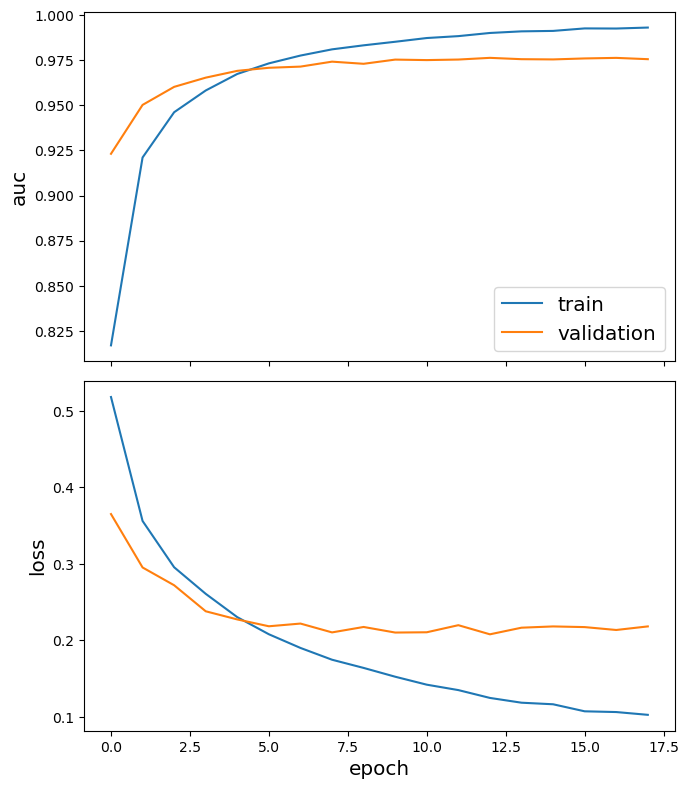

In [21]:
sg.utils.plot_history(history)

In [22]:
train_metrics = model.evaluate(train_flow, verbose=2)
test_metrics = model.evaluate(test_flow, verbose=2)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

428/428 - 9s - loss: 0.0716 - auc: 0.9964 - 9s/epoch - 20ms/step
476/476 - 10s - loss: 0.2094 - auc: 0.9761 - 10s/epoch - 21ms/step

Train Set Metrics of the trained model:
	loss: 0.0716
	auc: 0.9964

Test Set Metrics of the trained model:
	loss: 0.2094
	auc: 0.9761


In [23]:
def predict(model, flow, iterations=10):
    predictions = []
    for _ in range(iterations):
        predictions.append(model.predict(flow, workers=-1).flatten())

    return np.mean(predictions, axis=0)

In [24]:
test_pred = HinSAGELinkGenerator(G,
                                 batch_size=batch_size,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"],
                                seed=42).flow(edge_ids_test, edge_labels_test, seed=42)

In [25]:
predictions = predict(model, test_pred)

476/476 [==============================] - 10s 22ms/step


In [26]:
middle = int(len(predictions)/2)

In [27]:
np.mean(predictions[:middle])

0.8994341

In [28]:
np.mean(predictions[middle:])

0.079774484

In [29]:
test = predictions[(predictions>0.5) | (predictions<0.5)]
test = test>0.5

In [30]:
test = test.astype('int8')

(array([25466.,  1525.,  1079.,   962.,   998.,  1145.,  1479.,  2108.,
         3741., 22359.]),
 array([1.04648679e-09, 9.99999568e-02, 1.99999899e-01, 2.99999863e-01,
        3.99999797e-01, 4.99999762e-01, 5.99999726e-01, 6.99999690e-01,
        7.99999595e-01, 8.99999559e-01, 9.99999523e-01]),
 <BarContainer object of 10 artists>)

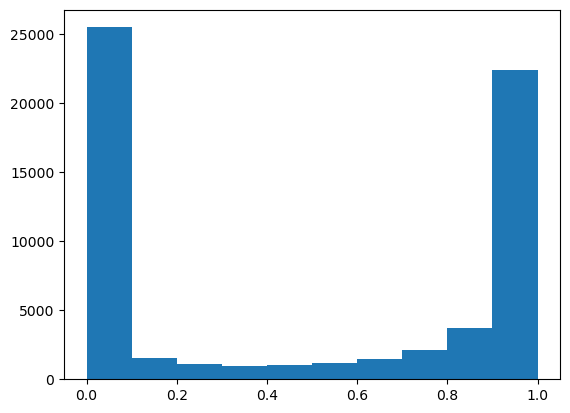

In [31]:
plt.hist(predictions)

In [32]:
np.where((predictions>0.9) | (predictions<0.1))

(array([    0,     1,     2, ..., 60858, 60860, 60861]),)

In [33]:
sum(test == edge_labels_test[np.where((predictions>0.5) | (predictions<0.5))])/len(test)

0.9451053202326575

In [34]:
len(test)/len(predictions)

1.0

In [35]:
model.save(f"./model/gbif_batch_{batch_size}_layer_{hinsage_layer_sizes[0]}_m_to_s")

INFO:tensorflow:Assets written to: ./model/gbif_batch_128_layer_1024_m_to_s/assets


INFO:tensorflow:Assets written to: ./model/gbif_batch_128_layer_1024_m_to_s/assets
